In [1]:
#https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=1449&context=creativecomponents
#https://pages.databricks.com/rs/094-YMS-629/images/financial-fraud-detection-decision-tree.html
#https://scholarworks.rit.edu/cgi/viewcontent.cgi?article=11833&context=theses    
#https://www.kaggle.com/hassanamin/credit-card-fraud-detection-using-random-forest

In [2]:
#!pip install missingno

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from scipy import stats
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import SGDClassifier

In [4]:
data = pd.read_csv('fraud.csv')

In [5]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Observation:
    1.step- maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 dayssimulation).
             means each hour of one month: for example, each record with step = 1 means it happened in the first hour on the 
            first day of the experimental month, and each record with step = 744 occurred in the last hour of the month.
            24 hours * 31 days = 744step

    2.type - Type is a categorical variable involving 5 different transaction types, including CASH-IN,
            CASH-OUT, DEBIT, PAYMENT and TRANSFER. CASH-IN means the customer’s account
            balance increased with cash inflow; CASH-OUT is opposite to CASH-IN, with cash outflow to
            decrease the account balance; DEBIT signifies sending money from the mobile service
            (electronic wallet) to a bank account; PAYMENT denotes customers paying goods or services to
            merchants, which will reduce customer’s account balances and increase merchants’ account
            balances; TRANSFER is the process of transferring money between users.

    3.amount - amount of the transaction in local currency.

    4.nameOrig - customer who started the transaction

    5.oldbalanceOrg - initial balance before the transaction

    6.newbalanceOrig - new balance after the transaction

    7.nameDest - customer who is the recipient of the transaction

    8.oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for 
                        customers that start with M (Merchants).

    9.newbalanceDest - new balance recipient after the transaction. Note that there is not information for 
                        customers that start with M (Merchants).

    10.isFraud - This is the transactions made by the fraudulent agents inside the simulation. 
                  In this specific dataset the fraudulent behavior of the agents aims to
                   profit by taking control or customers accounts and try to empty the funds by 
                   transferring to another account and then cashing out of the system.

    11.isFlaggedFraud - isFlaggedFraud is an additional attribute that the mobile service system used for controlling
                    massive transfers. According to the definition, when there was an attempt to transfer more than
                    200,000 units (in local currency) in a single transaction, isFlaggedFraud would be set to 1;
                    otherwise it would be 0. It doesn’t have a definite relation with isFraud.


 '''There
are 11 attributes in total, including 7 independent variables representing the features of a
transaction, 1 dependent variable standing for the status of a transaction, and 3 variables that are
not considered as relevant influencers, which will be dropped'''

## Exploratory Data Analysis

In [6]:
data.shape

(6362620, 11)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
Fraud = data[data['isFraud'] == 1]
Valid = data[data['isFraud'] == 0]

print("Fraud Transactions",len(Fraud))
print("Valid Tansaction",len(Valid))

Fraud Transactions 8213
Valid Tansaction 6354407


In [10]:
print("Amount details of fradulent transacation")
print(Fraud.amount.describe())
print('\n')
print("Amount details of Valid transacation")
print(Valid.amount.describe())

Amount details of fradulent transacation
count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64


Amount details of Valid transacation
count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64


In [11]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Visualization

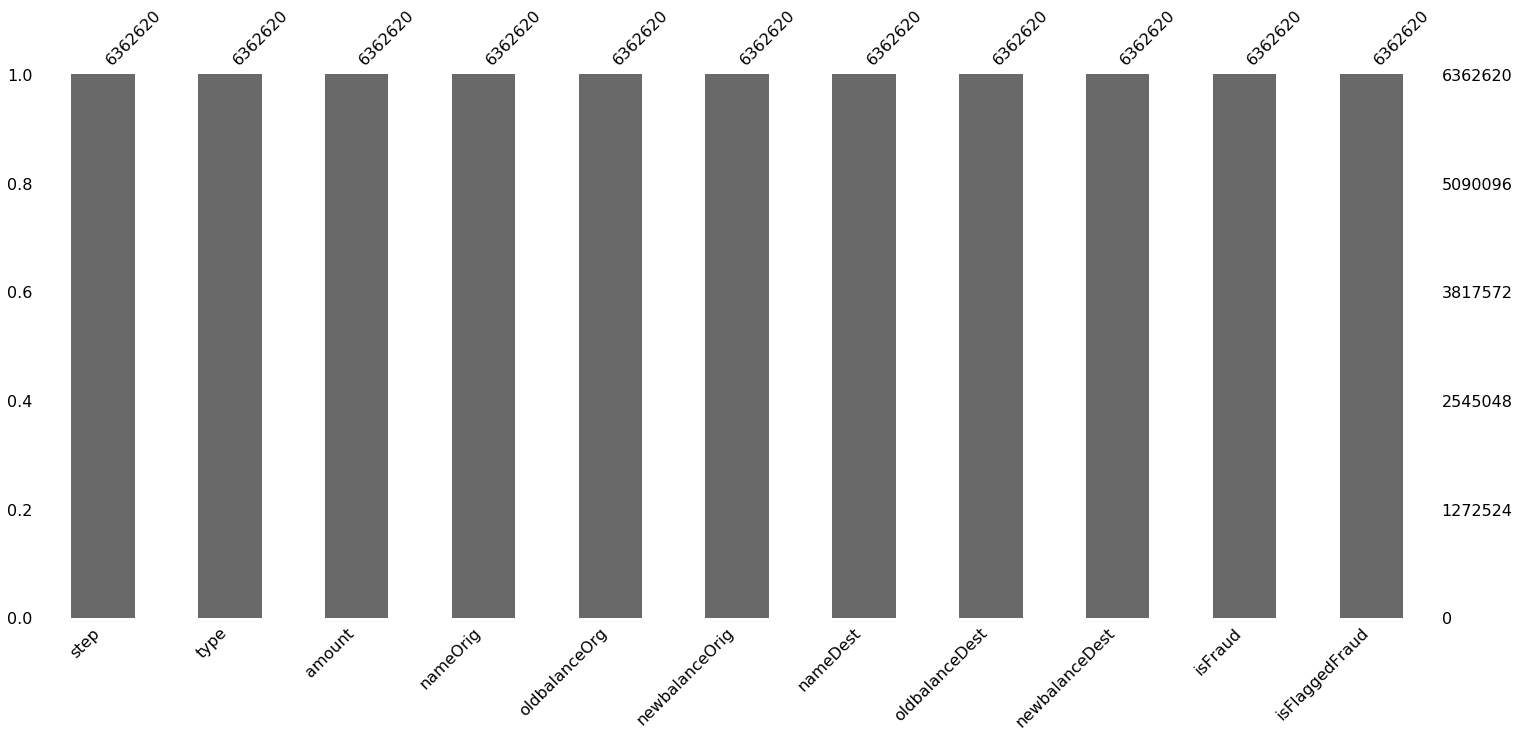

In [12]:
## null count analysis
p=msno.bar(data)

C:\Users\Acer\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


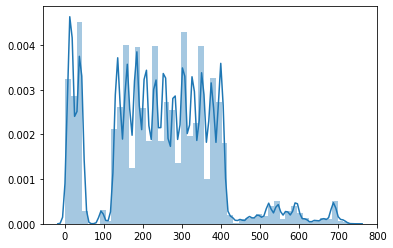

In [13]:
# distribution of Time
time = data['step'].values
sns.distplot(time)

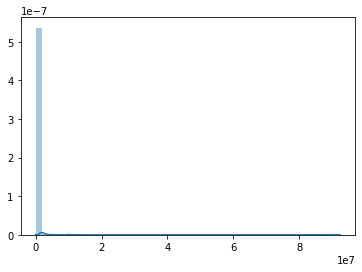

In [14]:
#amount distribution
amount = [data['amount'].values]
sns.distplot(amount)

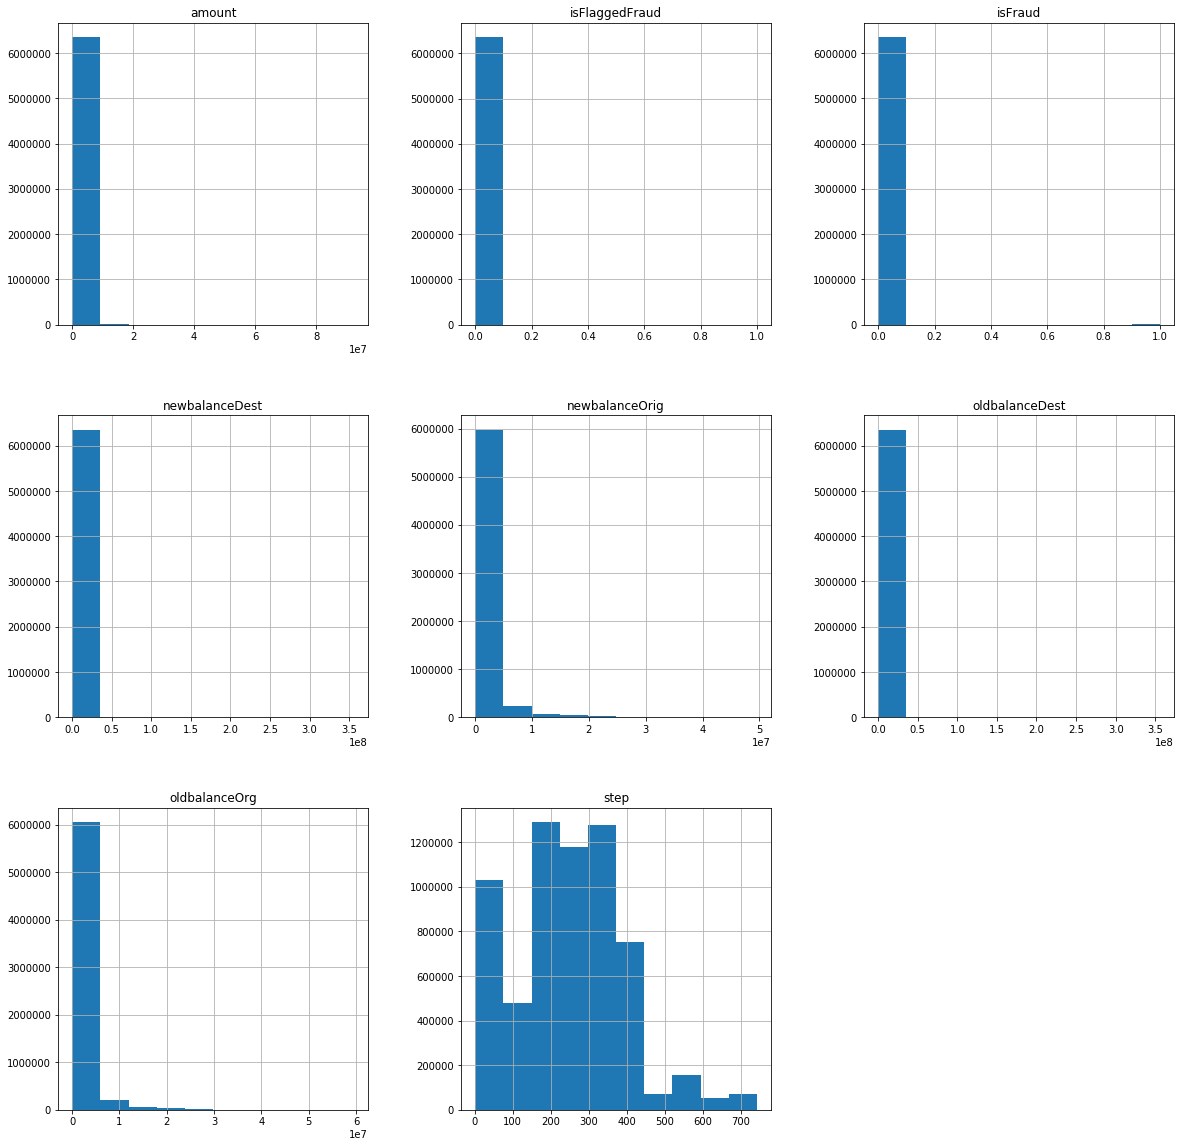

In [15]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

### Feature: isFraud

In [16]:
print(data.groupby('isFraud')['amount'].count())

isFraud
0    6354407
1       8213
Name: amount, dtype: int64


isFraud
0    6354407
1       8213
Name: amount, dtype: int64


--> legitimate cases (isFraud = 0):
   99.87%

--> Fraudalent cases (isFraud = 1):
   0.13%


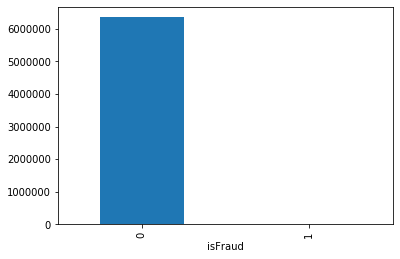

In [17]:
data.groupby('isFraud')['amount'].count().plot.bar()
print(data.groupby('isFraud')['amount'].count())
print('\n')
print('--> legitimate cases (isFraud = 0):\n   {}%'.format(100 - round(data['isFraud'].mean()*100, 2)))
print('\n--> Fraudalent cases (isFraud = 1):\n   {}%'.format(round(data['isFraud'].mean()*100, 2)))

### Observation:
Data is highly imbalanced in the two classes, with only 8213 fraudulent cases (0.13%) and 6,354,407(99.87%)legitimatecases to mitigate the effect caused by skewness, stratified sampling can beadopted to create subsamples, in which raudulent and non-fraudulent transactionswill be equally distributed. 

By above analysis we can see that data is highly imbalanced and distrubution looks skewed if we build model on top this data the model may become majority class dependent so,we need to try balancing data as much as we can using undersampling and oversampling.

## FeatureWise Analysis

### Feature: type

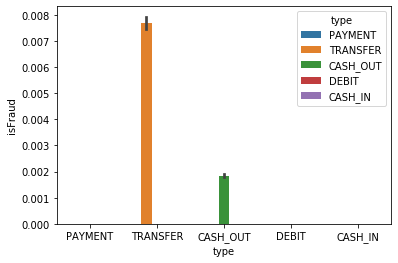

In [18]:
sns.barplot('type','isFraud',hue='type',data=data)

### Observation
    type is a categorical variable with 5 possible values: CASH-IN, CASH-OUT, DEBIT,PAYMENT and TRANSFER. To explore each type value is crucial or not for the research,It turns out all the fraudulent records were either CASH_OUT or TRANSFER. To simply later analysis, we decided to only keep these two types and the other three were left out. A dummydata frame was created to extract type.CASH_OUT and type.TRANSFER, which were combined with all the other variables.

In [19]:
#droping CASH-IN,PAYMENT,DEBIT because they won't present in case of fraudulent records
#undersampling without lossing important data
data = data.loc[data['type'].isin(['CASH_OUT', 'TRANSFER']),:]
print('The new data now has ', len(data), ' transactions.')

The new data now has  2770409  transactions.


In [20]:
dummies = pd.get_dummies(data.type)
dummies

,CASH_OUT,TRANSFER
2,0,1
3,1,0
15,1,0
19,0,1
24,0,1
...,...,...
6362615,1,0
6362616,0,1
6362617,1,0
6362618,0,1


In [21]:
data = pd.concat([data,dummies],axis=1)
data = data.drop(['type'],axis = 1)
data

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,TRANSFER
2,1,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,0,1
3,1,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0,1,0
15,1,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0,1,0
19,1,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,0,1
24,1,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0,1,0
6362616,743,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0,1,0
6362618,743,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0,0,1


### Feature: oldbalanceOrig & oldbalanceDest

Wall time: 1min 8s


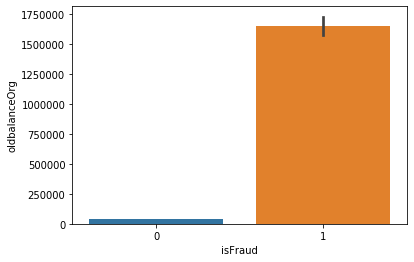

In [22]:
%%time
sns.barplot('isFraud','oldbalanceOrg',data=data)

In [ ]:
%%time
sns.barplot('isFraud','oldbalanceDest',hue='isFraud',data=data)

### Observation:
        in the distribution of legit and fraudulent records in oldbalanceOrig and oldbalanceDest.The bar plot indicates fraudulent transactions were more likely to appear in accounts with higher oldbalanceOrig, which means accounts with higher initial balance are more tend to be attacked. As for the bar plot, it implies that accounts with lower initial balance are more likely to be the receivers involved in a fraud. 

### Feature: nameOrig & nameDest

In [ ]:
data['freq_nameDest'] = data.groupby('nameDest')['isFraud'].transform('count')
data['freq_nameOrig'] = data.groupby('nameOrig')['isFraud'].transform('count')
print(data['freq_nameDest'])
print('\n')
print(data['freq_nameOrig'])

### Observation:

nameOrig and nameDest are ID numbers for customers or merchants. Theoretically, if they have
any relation with isFraud, it could be the frequency of the occurrence of ID numbers — IDs that
show up frequently may have higher possibility of participating in frauds. To figure out whether
the hypothesis is correct or not, all the IDs which appeared more than once were picked out and
listed with their corresponding account status.

Observing the two tables we just created, the frequency of nameOrig or nameDest doesn’t
appear to have a significant relationship with account status. For example, all the receiver IDs
appeared over 100 times had never joined in a single fraud, yet some ID numbers that only
showed up for a few times were proved to participated in frauds. The occurrences of ID numbers
were random and have neither a positive nor a negative relation with isFraud, thus nameOrig or
nameDest are omitted from later analysis.

### Feature:isFlaggedFraud

In [ ]:
print(data.groupby('isFlaggedFraud')['amount'].count())

### Observation:
The definition of isFlaggedFraud seems to be inconsistent with the data. As stated in the
description of dataset, in order to control large transfers from one account to another, the system
will mark the single transactions with more than 200,000 transferred as isFlaggedFraud =1.
Nonetheless, isFlaggedFraud can remain 0 despite the condition was met, and there were only
16 “isFlaggedFraud = 1” out of over 6 million entries. 

In [ ]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In Correlation matrix we can observe that isFlaggedFraud don't have any correlation with anyy other features,so we can remove this feature because it won't help us in prediction.

In [ ]:
# Defining inaccuracies in originator and recipient balances
data['origBalance_inacc'] = (data['oldbalanceOrg'] - data['amount']) -data['newbalanceOrig']
data['destBalance_inacc'] = (data['oldbalanceDest'] + data['amount']) -data['newbalanceDest']

In [ ]:
data['origBalance_inacc']

## Data Cleaning and transformtion

In [ ]:
data

In [ ]:
data = data.drop(['isFlaggedFraud','nameOrig','nameDest','isFlaggedFraud'],axis = 1)
data

In [ ]:
# Check that there are no negative amounts
print('Number of transactions where the transaction amount is negative: ' +
str(sum(data['amount'] < 0)))

In [ ]:
# Check instances where transacted amount is 0
print('Number of transactions where the transaction amount is zero: ' +
str(sum(data['amount'] == 0)))

In [ ]:
# Remove 0 amount values
data = data.loc[data['amount'] > 0,:]

In [ ]:
data.groupby('TRANSFER')['isFraud'].count()

In [ ]:
plt.figure(figsize=(12,10)) 
p=sns.heatmap(data.corr(), annot=True,cmap ='RdYlGn')  

## Training Models

In [ ]:
data.groupby('isFraud').count()

In [ ]:
#seperating the X and the Y from the dataset
X=data.drop(['isFraud'], axis=1)
Y=data["isFraud"]
print(X.shape)
print(Y.shape)
#getting just the values for the sake of processing (its a numpy array with no columns)
X_data=X.values
Y_data=Y.values

In [ ]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(ratio=0.5)

X_data,Y_data= os.fit_sample(X_data,Y_data)
X_data.shape,Y_data.shape

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

In [ ]:
# Feature Scaling So that data in all the columns are to the same scale
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Logestic Regression

In [ ]:
clf = SGDClassifier(alpha=1,class_weight='balanced',penalty='l2',loss='log')
clf.fit(X_train,Y_train)
y_pred=clf.predict(X_test)

In [ ]:

classification = classification_report(Y_test, y_pred)
confusion = confusion_matrix(Y_test, y_pred)
macro_f1Score = f1_score(Y_test, y_pred,average='macro')
micro_f1Score = f1_score(Y_test, y_pred,average='micro')

print('Classification Report \n',classification)
print('\n')
print('Cofusion Metrics \n',confusion)
print('\n')
print('Macro F1score',macro_f1Score)
print('Micro F1score',micro_f1Score)

<pre>
Observation:
Since the Linear Regression is Classification type algorithm i am using classification report where we can measure or evaluate our model with precision,recall,f1 score and confusion metrics,F1 score.

From observation,Linear Regression is performing well but let's see with some other algorithm performance.
</pre>

### Decision_tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
classification = classification_report(Y_test, y_pred)
confusion = confusion_matrix(Y_test, y_pred)
macro_f1Score = f1_score(Y_test, y_pred,average='macro')
micro_f1Score = f1_score(Y_test, y_pred,average='micro')

print('Classification Report \n',classification)
print('\n')
print('Cofusion Metrics \n',confusion)
print('\n')
print('Macro F1score',macro_f1Score)
print('Micro F1score',micro_f1Score)

<pre>
Observation:
Decision tree performance is more accurate in compare to Logestic Regression.
</pre>

### Random_forest

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,Y_train)

y_pred=clf.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
classification = classification_report(Y_test, y_pred)
confusion = confusion_matrix(Y_test, y_pred)
macro_f1Score = f1_score(Y_test, y_pred,average='macro')
micro_f1Score = f1_score(Y_test, y_pred,average='micro')

print('Classification Report \n',classification)
print('\n')
print('Cofusion Metrics \n',confusion)
print('\n')
print('Macro F1score',macro_f1Score)
print('Micro F1score',micro_f1Score)

<pre>
Observation:
Random forest performance is more accuratein term of f1 score in compare to Decision tree.

From above evaluation metrics, i can observe that tree based models were performing better than logestic regression.
</pre>